In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve
)

In [14]:
df=pd.read_csv('../data/final/Classification_table.csv')

In [15]:
df.shape

(82180, 44)

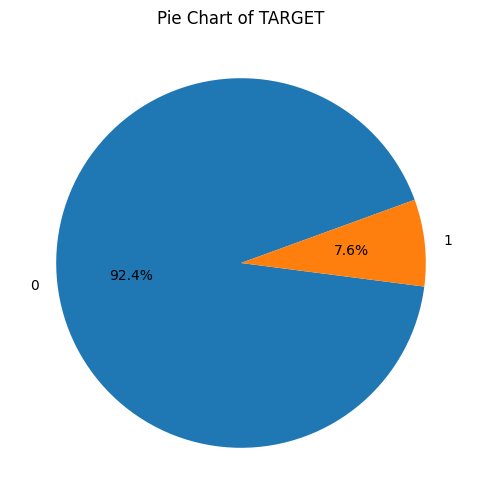

In [16]:
value_counts = df["TARGET"].value_counts()
top_n = 6
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
pie_data = value_counts.head(top_n)
axes.pie(
    pie_data,
    labels=pie_data.index.tolist(),
    autopct='%1.1f%%',
    startangle=20
)
axes.set_title('Pie Chart of TARGET')
plt.show()

In [17]:
final_features_classification = [

    # numeric (raw / ratios)
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',

    'Credit_to_Income_Ratio',
    'Annuity_to_Income_Ratio',
    'Annuity_to_Credit_Ratio',

    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',

    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_REGISTRATION',
    'DAYS_LAST_PHONE_CHANGE',
    'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT',

    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',

    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_YEAR',

    'bureau_overdue_months',
    'total_active_bureau_loans',

    'pos_num_loans',
    'pos_mean_cnt_instalment',

    'inst_mean_payment_delay',
    'inst_mean_payment_rate',

    'avg_prev_amt_requested',
    'prev_num_approved',
    'prev_num_rejected',

    'max_cc_sk_dpd_def',
    'CC_PAYMENT_RATIO',
    'DELINQUENCY_SEVERITY',

    # binary flags
    'HAS_CC_DELINQUENCY',
    'NO_CC_PAYMENT_FLAG',

    # categorical (encode later)
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',

    # target
    'TARGET'
]


In [18]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])

In [19]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['number','int64','float64']).columns

Logistic Regression (baseline)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_val_cat = ohe.transform(X_val[cat_cols])

In [22]:
X_train_num = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
X_val_num = X_val[num_cols].replace([np.inf, -np.inf], np.nan)

X_train_num = X_train_num.fillna(X_train_num.median())
X_val_num = X_val_num.fillna(X_train_num.median())

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)

In [23]:
X_train_final = pd.concat([
    pd.DataFrame(np.asarray(X_train_num), index=X_train.index),
    pd.DataFrame(np.asarray(X_train_cat), index=X_train.index)
], axis=1)

X_val_final = pd.concat([
    pd.DataFrame(np.asarray(X_val_num), index=X_val.index),
    pd.DataFrame(np.asarray(X_val_cat), index=X_val.index)
], axis=1)

In [24]:
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')

In [26]:
mlflow.set_experiment("Target_Classification")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model1.fit(X_train_final, y_train)

    preds = model1.predict_proba(X_val_final)[:,1]

    # metrics
    roc_auc = roc_auc_score(y_val, preds)
    pr_auc = average_precision_score(y_val, preds)
    precision = precision_score(y_val, model1.predict(X_val_final))
    recall = recall_score(y_val, model1.predict(X_val_final))
    f1 = f1_score(y_val, model1.predict(X_val_final))
    accuracy = accuracy_score(y_val, model1.predict(X_val_final))
    fpr, tpr, _ = roc_curve(y_val, preds)
    ks = np.max(tpr - fpr)

    mlflow.log_param("model_type", "LogesticRegression")
    mlflow.log_param("features_count", X.shape[1])

    mlflow.log_metric("roc_auc", float(roc_auc))
    mlflow.log_metric("pr_auc", float(pr_auc))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_metric("f1", float(f1))
    mlflow.log_metric("accuracy", float(accuracy))
    mlflow.log_metric("ks_statistic", float(ks))

    mlflow.sklearn.log_model(
        model1,
        artifact_path="model"
    )


2025/12/16 22:28:45 INFO mlflow.tracking.fluent: Experiment with name 'Target_Classification' does not exist. Creating a new experiment.
2025/12/16 22:28:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run gentle-crow-519 at: http://127.0.0.1:5000/#/experiments/2/runs/8a4b2c24c6f74d9f9c6234b45d51f7ce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
